# Diffusion Mnist

In [1]:
# Install required libraries
!pip install torch torchvision einops matplotlib tqdm torchsummary torchviz


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch import nn
from einops import rearrange
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchviz import make_dot


In [4]:
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def get_mnist_dataloader(train=True):
    dataset = datasets.MNIST(
        root="./data", train=train, download=True, transform=get_transforms()
    )
    dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=train)
    return dataloader

In [5]:
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, bias=False):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=bias),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=bias),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y


class CAB(nn.Module):
    def __init__(self, n_feat, reduction=16, bias=False):
        super(CAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(n_feat, n_feat, 3, padding=1, bias=bias),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_feat, n_feat, 3, padding=1, bias=bias),
        )
        self.ca = CALayer(n_feat, reduction, bias=bias)

    def forward(self, x):
        res = self.body(x)
        res = self.ca(res)
        return res + x  # Residual Connection



In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, channels, num_cabs_per_layer):
        super().__init__()
        layers = []
        for in_ch, out_ch, num_cabs in zip(channels[:-1], channels[1:], num_cabs_per_layer):
            layers.append(nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1))
            layers.extend([CAB(out_ch, reduction=Config.REDUCTION_FACTOR) for _ in range(num_cabs)])  # Add CABs
            layers.append(nn.ReLU())
        self.conv_layers = nn.Sequential(*layers)
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels[-1] * 7 * 7, latent_dim),
        )

    def forward(self, x):
        if Config.DEBUG:
            print(f"Encoder Input Shape: {x.shape}")
        x = self.conv_layers(x)
        if Config.DEBUG:
            print(f"Encoder After Conv Layers: {x.shape}")
        x = self.flatten(x)
        if Config.DEBUG:
            print(f"Encoder Output (Flattened): {x.shape}")
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim, channels, num_cabs_per_layer):
        super().__init__()
        self.channels = channels  # Save channels as a class attribute

        # Define the linear layer for latent-to-feature map transformation
        self.linear = nn.Linear(latent_dim, channels[0] * 7 * 7)


        layers = []
        for in_ch, out_ch, num_cabs in zip(channels[:-1], channels[1:], num_cabs_per_layer):
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))  # Deconvolution layer
            layers.extend([CAB(out_ch, reduction=Config.REDUCTION_FACTOR) for _ in range(num_cabs)])  # Add CABs
            if out_ch != 1:  # Activation: ReLU for intermediate layers, Sigmoid for the final layer
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Sigmoid())

        self.deconv_layers = nn.Sequential(*layers)

    def forward(self, z):
        if Config.DEBUG:
            print(f"Decoder Input Shape: {z.shape}")

        # Latent to feature map
        x = self.linear(z)
        if Config.DEBUG:
            print(f"After Linear Layer: {x.shape} (Expected: [batch_size, {self.channels[0] * 7 * 7}])")

        x = rearrange(x, "b (c h w) -> b c h w", c=self.channels[0], h=7, w=7)
        if Config.DEBUG:
            print(f"After Reshape: {x.shape} (Expected: [batch_size, {self.channels[0]}, 7, 7])")

        # Pass through the deconvolution layers
        x = self.deconv_layers(x)
        if Config.DEBUG:
            print(f"Decoder Output Shape: {x.shape} (Expected: [batch_size, 1, 28, 28])")

        return x


In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim, Config.ENCODER_CHANNELS, Config.NUM_CABS_ENCODER)
        self.decoder = Decoder(latent_dim, Config.DECODER_CHANNELS, Config.NUM_CABS_DECODER)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        if Config.DEBUG:
            print(f"Autoencoder Input Shape: {x.shape}")
        z = self.encoder(x)
        if Config.DEBUG:
            print(f"Latent Representation Shape: {z.shape}")
        out = self.decoder(z)
        if Config.DEBUG:
            print(f"Autoencoder Output Shape: {out.shape}")
        return out


In [8]:
def train_autoencoder():
    # Load data
    train_loader = get_mnist_dataloader(train=True)

    # Initialize model, loss, and optimizer
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    summary(autoencoder, input_size=(1, Config.IMAGE_SIZE, Config.IMAGE_SIZE))

    # Visualize the model architecture
    dummy_input = torch.randn(1, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(Config.DEVICE)
    dummy_output = autoencoder(dummy_input)
    dot = make_dot(dummy_output, params=dict(autoencoder.named_parameters()))
    dot.render(os.path.join(Config.SAVE_DIR, "autoencoder_architecture"), format="png")
    print(f"Model architecture visualization saved to {Config.SAVE_DIR}/autoencoder_architecture.png")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=Config.LR)

    loss_history = []
    # Training loop
    autoencoder.train()
    for epoch in range(Config.EPOCHS):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{Config.EPOCHS}")
        for images, _ in pbar:
            images = images.to(Config.DEVICE)
            # Forward pass
            recon_images = autoencoder(images)
            loss = criterion(recon_images, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

        average_loss = epoch_loss / len(train_loader)
        loss_history.append(average_loss)
        print(f"Epoch {epoch + 1}: Average Loss: {average_loss:.4f}")

    # Save the trained model
    save_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    torch.save(autoencoder.state_dict(), save_path)
    print(f"Autoencoder training completed and model saved at: {save_path}")

    # Plot the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, Config.EPOCHS + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def train_model(model, dataloader):
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR)
    for epoch in range(Config.EPOCHS):
        for images, _ in dataloader:
            images = images.to(Config.DEVICE)
            loss = model.training_step(images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{Config.EPOCHS}, Loss: {loss.item()}")


In [10]:
class Config:
    DATASET_NAME = "MNIST"
    IMAGE_SIZE = 28
    LATENT_DIM = 64
    SAVE_DIR = "/content/drive/My Drive/AI/Projects/diffusion mnist/models"
    MODEL_NAME = "Autoencoder_with_CAB.pth"
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encoder/Decoder Configurations
    ENCODER_CHANNELS = [1, 16, 32]         # Input -> Intermediate -> Latent
    DECODER_CHANNELS = [32, 16, 1]         # Latent -> Intermediate -> Output
    NUM_CABS_ENCODER = [1, 0]              # Number of CABs in each encoder layer
    NUM_CABS_DECODER = [1, 0]              # Number of CABs in each decoder layer
    REDUCTION_FACTOR = 8                  # Channel attention reduction factor
    DEBUG = False                          # Enable debugging prints

In [11]:
os.makedirs(Config.SAVE_DIR, exist_ok=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2           [-1, 16, 14, 14]           2,304
              ReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           2,304
 AdaptiveAvgPool2d-5             [-1, 16, 1, 1]               0
            Conv2d-6              [-1, 2, 1, 1]              32
              ReLU-7              [-1, 2, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]              32
           Sigmoid-9             [-1, 16, 1, 1]               0
          CALayer-10           [-1, 16, 14, 14]               0
              CAB-11           [-1, 16, 14, 14]               0
             ReLU-12           [-1, 16, 14, 14]               0
           Conv2d-13        

Epoch 1/10: 100%|██████████| 938/938 [00:16<00:00, 56.07it/s, Loss=0.0325]


Epoch 1: Average Loss: 0.0633


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 57.94it/s, Loss=0.0146]


Epoch 2: Average Loss: 0.0199


Epoch 3/10: 100%|██████████| 938/938 [00:17<00:00, 54.92it/s, Loss=0.0125]


Epoch 3: Average Loss: 0.0141


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 57.75it/s, Loss=0.0091]


Epoch 4: Average Loss: 0.0108


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 57.62it/s, Loss=0.0073]


Epoch 5: Average Loss: 0.0085


Epoch 6/10: 100%|██████████| 938/938 [00:15<00:00, 58.67it/s, Loss=0.0067]


Epoch 6: Average Loss: 0.0067


Epoch 7/10: 100%|██████████| 938/938 [00:15<00:00, 59.19it/s, Loss=0.0060]


Epoch 7: Average Loss: 0.0058


Epoch 8/10: 100%|██████████| 938/938 [00:15<00:00, 59.12it/s, Loss=0.0046]


Epoch 8: Average Loss: 0.0052


Epoch 9/10: 100%|██████████| 938/938 [00:15<00:00, 59.47it/s, Loss=0.0044]


Epoch 9: Average Loss: 0.0048


Epoch 10/10: 100%|██████████| 938/938 [00:15<00:00, 59.02it/s, Loss=0.0053]


Epoch 10: Average Loss: 0.0045
Autoencoder training completed and model saved at: /content/drive/My Drive/AI/Projects/diffusion mnist/models/Autoencoder_with_CAB.pth


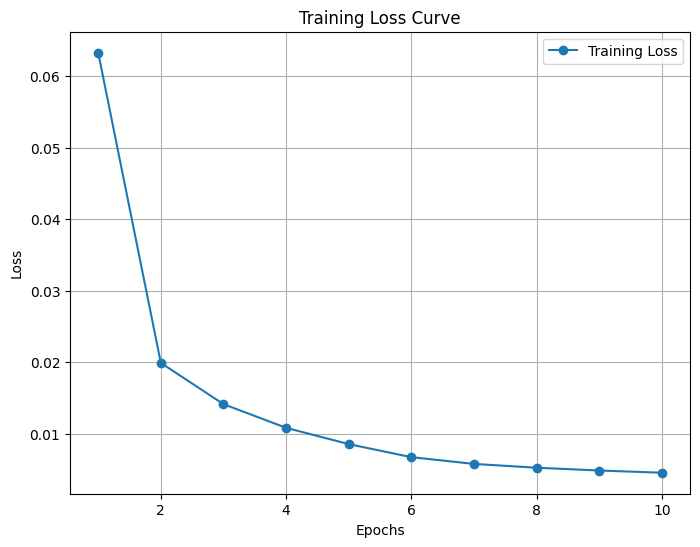

In [12]:
train_autoencoder()


In [13]:
def calculate_metrics(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    ssim_scores = []
    psnr_scores = []

    for i in range(original.shape[0]):
        original_img = original[i, 0]
        reconstructed_img = reconstructed[i, 0]

        ssim_score = ssim(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())
        psnr_score = psnr(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

    return np.mean(ssim_scores), np.mean(psnr_scores)

In [14]:
def visualize_reconstructions():
    # Load the model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))
    autoencoder.eval()

    # Get test data
    test_loader = get_mnist_dataloader(train=False)
    images, _ = next(iter(test_loader))
    images = images.to(Config.DEVICE)

    # Reconstruct
    with torch.no_grad():
        recon_images = autoencoder(images)

    # Calculate metrics
    avg_ssim, avg_psnr = calculate_metrics(images, recon_images)
    print(f"Average SSIM: {avg_ssim:.4f}, Average PSNR: {avg_psnr:.2f}")

    # Visualization
    num_images = 10
    fig, axes = plt.subplots(2, num_images, figsize=(18, 6))
    fig.suptitle(f"SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f}", fontsize=16, y=0.92)

    for i in range(num_images):
        original_img = images[i][0].cpu().numpy()
        reconstructed_img = recon_images[i][0].cpu().numpy()

        # Original images
        axes[0, i].imshow(original_img, cmap="gray")
        ssim_score = ssim(original_img, reconstructed_img, data_range=1.0)
        axes[0, i].set_title(f"Original", fontsize=10)
        axes[0, i].axis("off")

        # Reconstructed images
        axes[1, i].imshow(reconstructed_img, cmap="gray")
        axes[1, i].set_title(f"Reconstructed\nSSIM: {ssim_score:.2f}", fontsize=10)
        axes[1, i].axis("off")

    # plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


<ipython-input-14-d7b8f594bd62>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))


Average SSIM: 0.9586, Average PSNR: 24.94


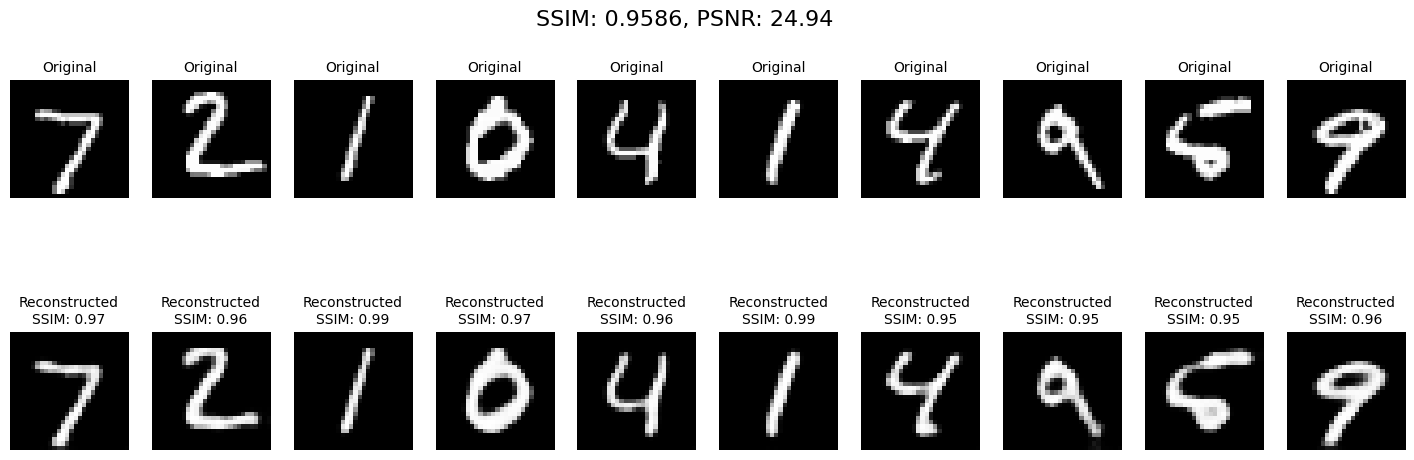

In [15]:
visualize_reconstructions()


In [19]:
def visualize_latent_space():
    # Load the trained model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    autoencoder.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)))
    autoencoder.eval()

    # Load the test data
    test_loader = get_mnist_dataloader(train=True)
    images, labels = next(iter(test_loader))
    images = images.to(Config.DEVICE)
    labels = labels.cpu().numpy()  # Move labels to CPU for visualization

    # Encode the images to the latent space
    with torch.no_grad():
        latents = autoencoder.encode(images).cpu().numpy()

    # Reduce dimensions to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Create a scatter plot with labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="tab10", s=40, alpha=0.8)
    plt.colorbar(scatter, label="Digit Label")

    # Annotate each point with its digit label
    for i, label in enumerate(labels):
        plt.annotate(str(label), (latents_2d[i, 0], latents_2d[i, 1]),
                     textcoords="offset points", xytext=(0, 2), ha='center', fontsize=8, color='black')

    plt.title("Latent Space Visualization with Labels", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


<ipython-input-19-19b3b8b4e12a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)))


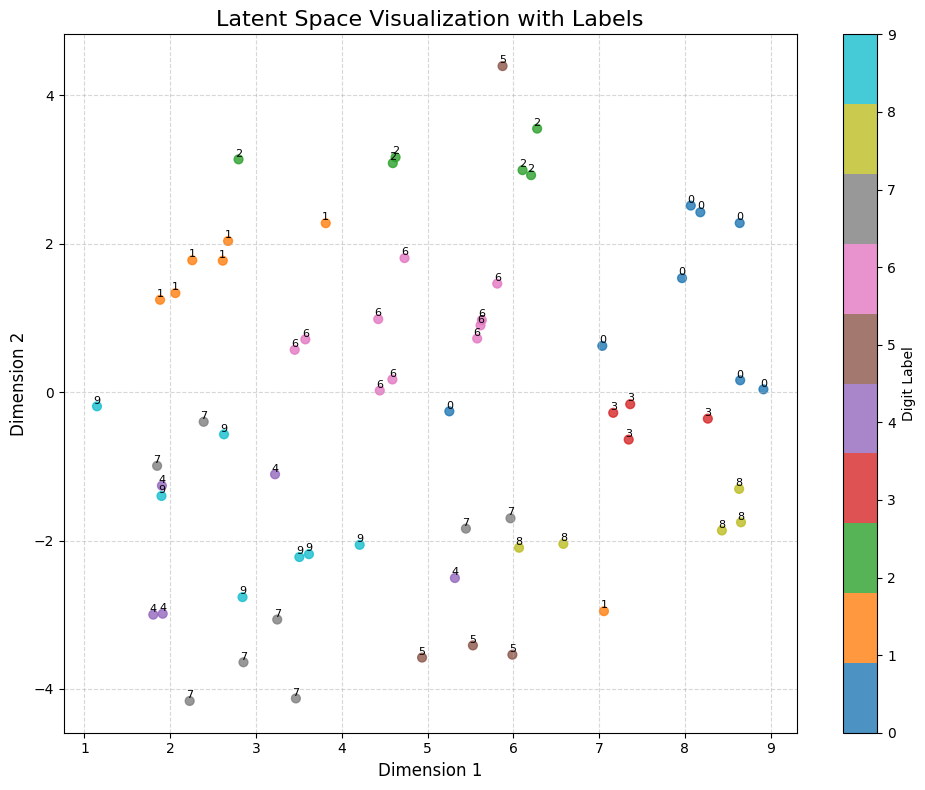

In [20]:
visualize_latent_space()

In [23]:
def visualize_latent_space():
    # Load the trained model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))
    autoencoder.eval()

    # Load the test data
    test_loader = get_mnist_dataloader(train=False)
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(Config.DEVICE)
    test_labels = test_labels.cpu().numpy()  # Move labels to CPU for visualization

    # Encode the images to the latent space
    with torch.no_grad():
        latents = autoencoder.encode(test_images).cpu().numpy()

    # Reduce dimensions to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Create a scatter plot with annotations
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=test_labels, cmap="tab10", s=40, alpha=0.8)
    plt.colorbar(scatter, label="Digit Label")

    # Annotate each point with its digit label
    for i, label in enumerate(test_labels):
        plt.annotate(
            str(label),
            (latents_2d[i, 0], latents_2d[i, 1]),
            textcoords="offset points",
            xytext=(0, 2),
            ha="center",
            fontsize=8,
            color="black",
        )

    plt.title("Latent Space Visualization (Single Test Batch) with Labels", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # # Entire training dataset
    # visualize_latent_space_full(
    #     autoencoder,
    #     get_mnist_dataloader(train=True),
    #     title="Latent Space Visualization (Entire Training Dataset)",
    #     save_path=os.path.join(Config.SAVE_DIR, "latent_space_train.png"),
    # )

    # Entire test dataset
    visualize_latent_space_full(
        autoencoder,
        test_loader,
        title="Latent Space Visualization (Entire Test Dataset)",
        save_path=os.path.join(Config.SAVE_DIR, "latent_space_test.png"),
    )


<ipython-input-23-e977b402ca11>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))


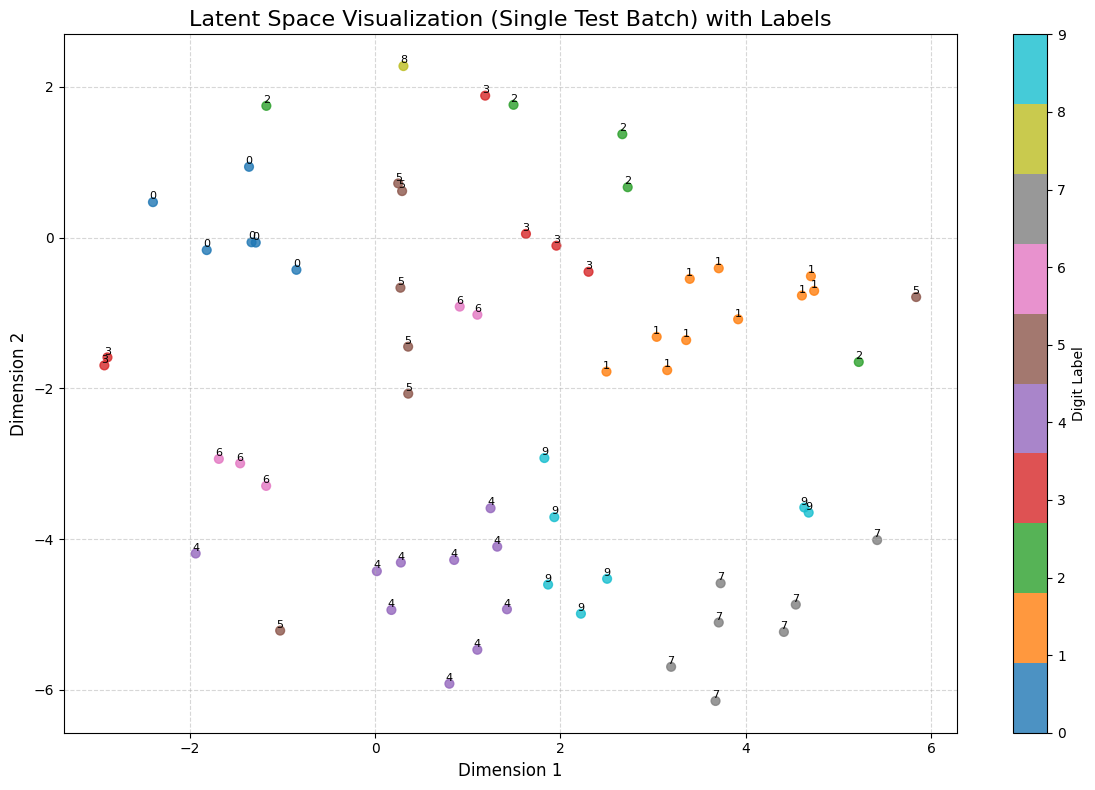

Encoding Latent Space Visualization (Entire Test Dataset): 100%|██████████| 157/157 [00:01<00:00, 128.60it/s]


Saved visualization to /content/drive/My Drive/AI/Projects/diffusion mnist/models/latent_space_test.png


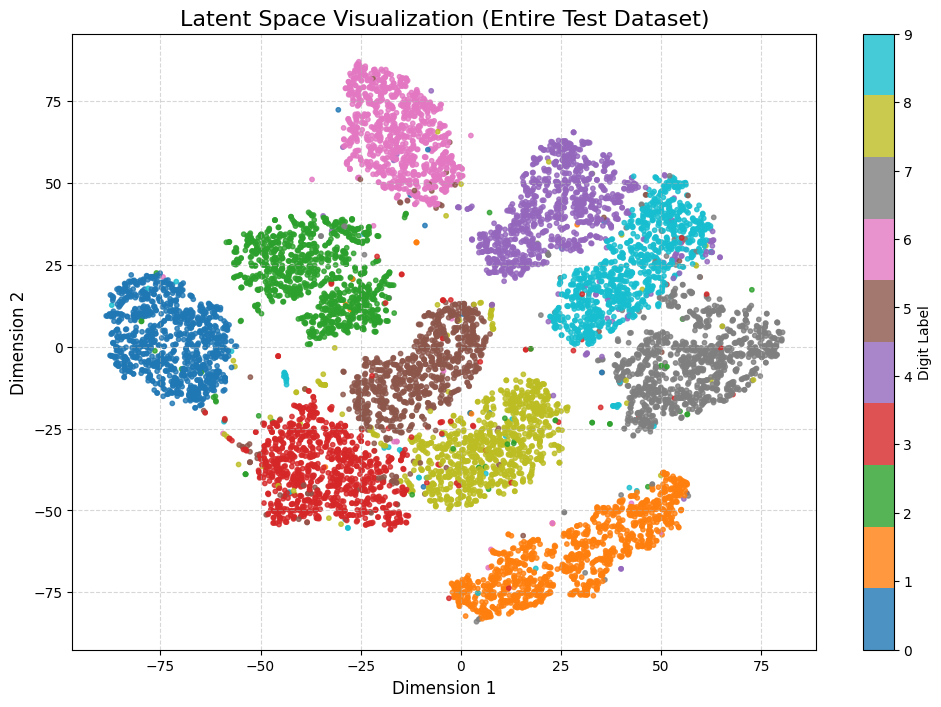

In [24]:
visualize_latent_space()